In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify as sq

In [2]:
#Load Source0: data
data = pd.read_excel("Dataset2.xlsx", sheet_name="Orders", index_col = 0)

#Convert "Column Name" format into "column_name" format
data.columns = [col.lower().replace(' ', '_') for col in data.columns]

In [3]:
#Select the columns for source table & calculate total value of each order: df
df = data.groupby(["customer_id","order_id","order_date"], as_index=False)["sales"].sum()
df

,customer_id,order_id,order_date,sales
0,AA-10315,CA-2014-128055,2014-03-31,726.548
1,AA-10315,CA-2014-138100,2014-09-15,29.500
2,AA-10315,CA-2015-121391,2015-10-04,26.960
3,AA-10315,CA-2016-103982,2016-03-03,4406.072
4,AA-10315,CA-2017-147039,2017-06-29,374.480
...,...,...,...,...
5004,ZD-21925,CA-2014-143336,2014-08-27,244.760
5005,ZD-21925,CA-2016-152471,2016-07-08,839.944
5006,ZD-21925,CA-2016-167682,2016-04-03,331.080
5007,ZD-21925,CA-2017-141481,2017-06-11,61.440


In [4]:
#Load dataframe of returned orders
rtn = pd.read_excel('Dataset2.xlsx', sheet_name='Return')
rtn.columns = [col.lower().replace(' ','_') for col in rtn.columns]
rtn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   returned  296 non-null    object
 1   order_id  296 non-null    object
dtypes: object(2)
memory usage: 4.8+ KB


In [5]:
#Exclude returned orders
df_rtn = df.merge(rtn, how='left', on='order_id')
df_rtn.drop(df_rtn[(df_rtn['returned']=='Yes')].index, inplace = True)
df_rtn.drop("returned", axis = 1, inplace=True)
df_rtn

,customer_id,order_id,order_date,sales
0,AA-10315,CA-2014-128055,2014-03-31,726.548
1,AA-10315,CA-2014-138100,2014-09-15,29.500
2,AA-10315,CA-2015-121391,2015-10-04,26.960
3,AA-10315,CA-2016-103982,2016-03-03,4406.072
4,AA-10315,CA-2017-147039,2017-06-29,374.480
...,...,...,...,...
5003,ZC-21910,US-2017-102288,2017-06-19,148.884
5005,ZD-21925,CA-2016-152471,2016-07-08,839.944
5006,ZD-21925,CA-2016-167682,2016-04-03,331.080
5007,ZD-21925,CA-2017-141481,2017-06-11,61.440


In [6]:
#Calculate rfm at the moment
from datetime import datetime
today = datetime(2017,12,31)
rfm = df_rtn.groupby('customer_id').agg({'order_date':'max', 'order_id':'size', 'sales': 'sum'}).reset_index()
rfm.columns = ['customer_id', 'max_date', 'frequency', 'monetary']
rfm['recency'] = (today-rfm['max_date']).dt.days
rfm.drop('max_date', axis=1, inplace=True)
rfm = rfm[['customer_id', 'recency', 'frequency', 'monetary']]
rfm

,customer_id,recency,frequency,monetary
0,AA-10315,185,5,5563.560
1,AA-10375,20,9,1056.390
2,AA-10480,260,4,1790.512
3,AA-10645,483,5,5073.975
4,AB-10015,416,3,886.156
...,...,...,...,...
786,XP-21865,83,9,2110.726
787,YC-21895,5,4,5438.650
788,YS-21880,10,8,6720.444
789,ZC-21910,55,12,7892.998


In [7]:
#Score RFM by using Quintiles
r_labels, f_labels, m_labels = range(5,0,-1), range(1,6), range(1,6)
rfm['r_score'] = pd.qcut(rfm['recency'], q=5, labels=r_labels)
rfm['f_score'] = pd.qcut(rfm['frequency'], q=5, labels=f_labels)
rfm['m_score'] = pd.qcut(rfm['monetary'], q=5, labels=m_labels)

rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str) 
rfm['rfm_score'] = rfm['rfm_score'].astype(int)
rfm

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
0,AA-10315,185,5,5563.560,2,2,5,225
1,AA-10375,20,9,1056.390,5,5,2,552
2,AA-10480,260,4,1790.512,2,1,3,213
3,AA-10645,483,5,5073.975,1,2,5,125
4,AB-10015,416,3,886.156,1,1,2,112
...,...,...,...,...,...,...,...,...
786,XP-21865,83,9,2110.726,3,5,3,353
787,YC-21895,5,4,5438.650,5,1,5,515
788,YS-21880,10,8,6720.444,5,4,5,545
789,ZC-21910,55,12,7892.998,4,5,5,455


In [8]:
#Load Segment defination: data
data = pd.read_excel('Dataset2.xlsx', sheet_name='Sheet2')
data.columns = [col.lower().replace(' ','_') for col in data.columns]
data

,segment,rfm_score
0,Champions,"555, 554, 544, 545, 454, 455, 445"
1,Loyal,"543, 444, 435, 355, 354, 345, 344, 335"
2,Potential Loyalist,"553, 551, 552, 541, 542, 533, 532, 531, 452, 4..."
3,New Customers,"512, 511, 422, 421, 412, 411, 311"
4,Promising,"525, 524, 523, 522, 521, 515, 514, 513, 425,42..."
5,Need Attention,"535, 534, 443, 434, 343, 334, 325, 324"
6,About To Sleep,"331, 321, 312, 221, 213, 231, 241, 251"
7,At Risk,"255, 254, 245, 244, 253, 252, 243, 242, 235, 2..."
8,Cannot Lose Them,"155, 154, 144, 214, 215, 115, 114, 113"
9,Hibernating customers,"332, 322, 233, 232, 223, 222, 132, 123, 122, 2..."


In [9]:
#Convert comma-seperated string to a list of rfm scores

data['rfm_score'] = data['rfm_score'].str.split(',')
data = data.explode('rfm_score').reset_index(drop=True)
data['rfm_score'] = data['rfm_score'].astype(int)
data.sort_values(by='rfm_score')
data.head(10)

,segment,rfm_score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
5,Champions,455
6,Champions,445
7,Loyal,543
8,Loyal,444
9,Loyal,435


In [10]:
#Segment customer base on R, F, M
seg = rfm.merge(data, how='left', on='rfm_score')
seg
rfm['segment'] = seg['segment']

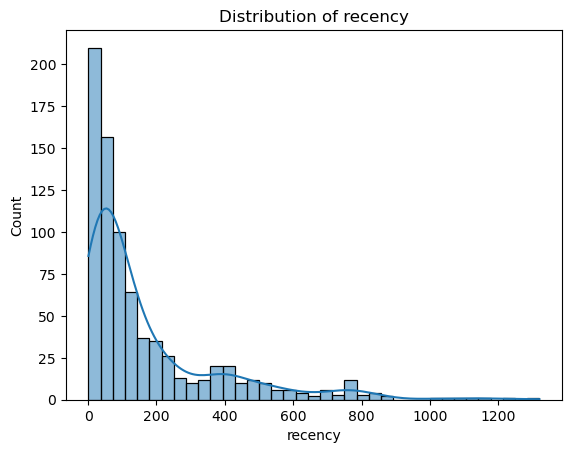

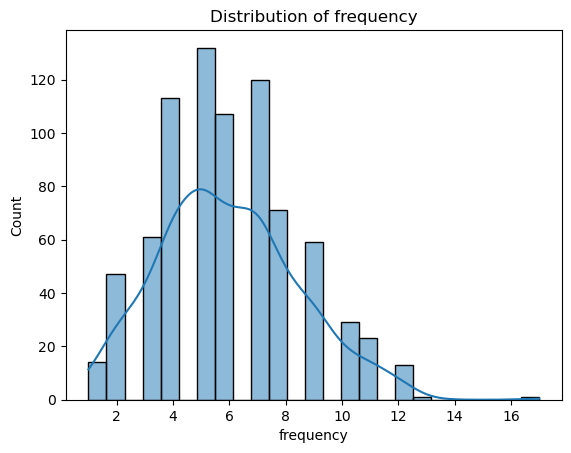

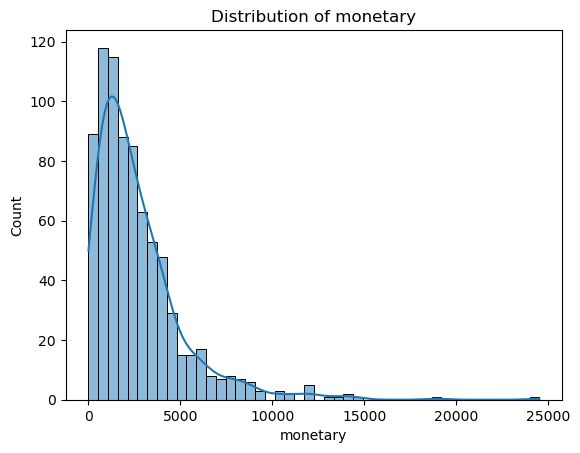

In [11]:
colnames = [rfm['recency'], rfm['frequency'], rfm['monetary']]
for col in colnames:
    sns.histplot(col, kde=True)
    plt.title('Distribution of %s' %col.name, loc="center")
    plt.show()

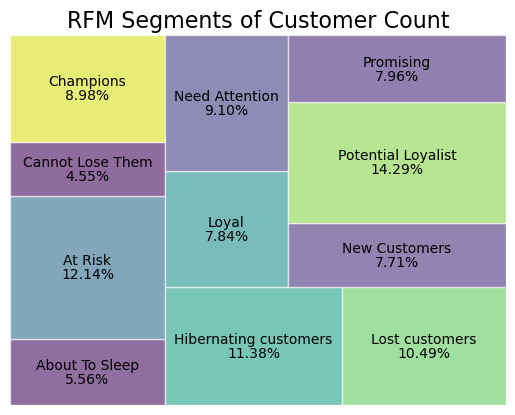

In [12]:
#Plot treemap - RFM Segments of Customer Count
data = rfm.groupby('segment')['customer_id'].count()

label = data.index
sizes = data.values
value = [f'{ (x/sizes.sum()*100) :.2f}%' for x in sizes]

sq.plot(sizes=sizes, label=label, value=value, alpha=0.6, bar_kwargs = dict(linewidth=1, edgecolor="white"))
plt.title("RFM Segments of Customer Count", fontsize=16)
plt.axis("off")
plt.show()

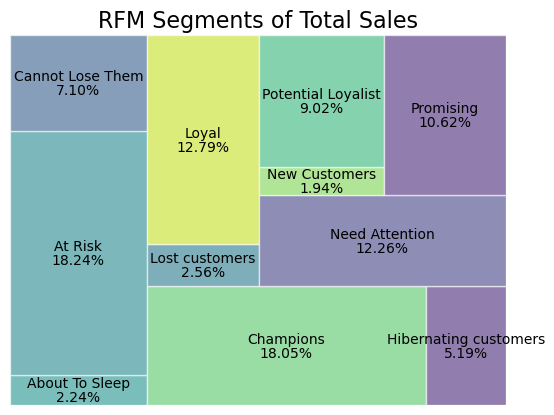

In [13]:
#Plot treemap - RFM Segments of Total Sales
data = rfm.groupby("segment")["monetary"].sum()
label = data.index
sizes = data.values
value = [f'{ (x/sizes.sum()*100) :.2f}%' for x in sizes]

sq.plot(sizes=sizes, label=label, value=value, alpha=0.6, bar_kwargs = dict(linewidth=1, edgecolor="white"))
plt.title("RFM Segments of Total Sales", fontsize=16)
plt.axis("off")
plt.show()

In [14]:
# export to csv file
# rfm.to_csv("RFM.csv")